# 002: Pipelines and Model Selection

This notebook demonstrated how the pipeline for a predictive model is created, including each processing step, and how model selection is carried out.

In [22]:
import pandas as pd
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

In [12]:
dict_types = {
    'Customer ID': 'category',
    'Age': 'int64',
    'Professional experience': 'int64',
    'Salary': 'int64',
    'ZIP code': 'category',
    'Family size': 'float64',
    'Average credit cards spend': 'float64',
    'Education level': 'category',
    'Mortgage': 'float64',
    'Loan': 'bool',
    'Securities account': 'bool',
    'Certificate of Deposit account': 'bool',
    'Online Banking': 'bool',
    'Credit Card': 'bool'
    }
data = pd.read_csv('../data/preprocessed/preprocessed_data.csv', dtype=dict_types)

In [13]:
data.dtypes

Customer ID                       category
Age                                  int64
Professional experience              int64
Salary                               int64
ZIP code                          category
Family size                        float64
Average credit cards spend         float64
Education level                   category
Mortgage                           float64
Loan                                  bool
Securities account                    bool
Certificate of Deposit account        bool
Online Banking                        bool
Credit Card                           bool
dtype: object

In [14]:
# function to load the dataset and return data for models
def load_dataset(full_path):
    dict_types = {
    'Customer ID': 'category',
    'Age': 'int64',
    'Professional experience': 'int64',
    'Salary': 'int64',
    'ZIP code': 'category',
    'Family size': 'float64',
    'Average credit cards spend': 'float64',
    'Education level': 'category',
    'Mortgage': 'float64',
    'Loan': 'bool',
    'Securities account': 'bool',
    'Certificate of Deposit account': 'bool',
    'Online Banking': 'bool',
    'Credit Card': 'bool'
    }
    dataframe = pd.read_csv(full_path, na_values='?', dtype=dict_types)
    dataframe = dataframe.drop(columns=['Customer ID', 'ZIP code'], axis=1)
    y = dataframe['Loan']
    X = dataframe.drop('Loan', axis=1)
    cat_ix = X.select_dtypes(include=['category']).columns
    num_ix = X.select_dtypes(include=['int64', 'float64', 'bool']).columns
    return X, y, cat_ix, num_ix

In [15]:
# function to evaluate a model
def evaluate_model(X, y, model):
 # define evaluation procedure
 cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
 # evaluate model
 scores = cross_validate(model, X, y, scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'], cv=cv, n_jobs=-1)
 return scores

In [16]:
# define models to test
def get_models():
	models, names = list(), list()
	# Dummy
	models.append(DummyClassifier(strategy='stratified'))
	names.append('Dummy')
	# DT
	models.append(DecisionTreeClassifier())
	names.append('DT')
	# LR
	models.append(LogisticRegression())
	names.append('LR')
	# NB
	models.append(GaussianNB())
	names.append('NB')
	# SVM
	models.append(SVC(gamma='scale'))
	names.append('SVM')
	# XGB
	models.append(XGBClassifier())
	names.append('XGB')
	return models, names

In [17]:
# load the dataset
X, y, cat_ix, num_ix = load_dataset('../data/preprocessed/preprocessed_data.csv')

The cell below builds a sklearn pipeline, and performs 10-fold cross validation on the training data, before testing on the test data.

Dummy
Average Accuracy: 0.83 (0.013)
Average F1: 0.095 (0.048)
Average Precision: 0.098 (0.048)
Average Recall: 0.094 (0.048)
Average ROC-AUC: 0.509 (0.023)

DT
Average Accuracy: 0.982 (0.007)
Average F1: 0.906 (0.037)
Average Precision: 0.911 (0.05)
Average Recall: 0.903 (0.044)
Average ROC-AUC: 0.947 (0.022)

LR
Average Accuracy: 0.956 (0.008)
Average F1: 0.73 (0.056)
Average Precision: 0.898 (0.046)
Average Recall: 0.617 (0.065)
Average ROC-AUC: 0.961 (0.014)

NB
Average Accuracy: 0.893 (0.013)
Average F1: 0.517 (0.051)
Average Precision: 0.458 (0.048)
Average Recall: 0.596 (0.069)
Average ROC-AUC: 0.933 (0.014)

SVM
Average Accuracy: 0.973 (0.006)
Average F1: 0.837 (0.04)
Average Precision: 0.981 (0.022)
Average Recall: 0.731 (0.057)
Average ROC-AUC: 0.984 (0.011)

XGB
Average Accuracy: 0.988 (0.006)
Average F1: 0.936 (0.03)
Average Precision: 0.964 (0.033)
Average Recall: 0.912 (0.045)
Average ROC-AUC: 0.998 (0.002)



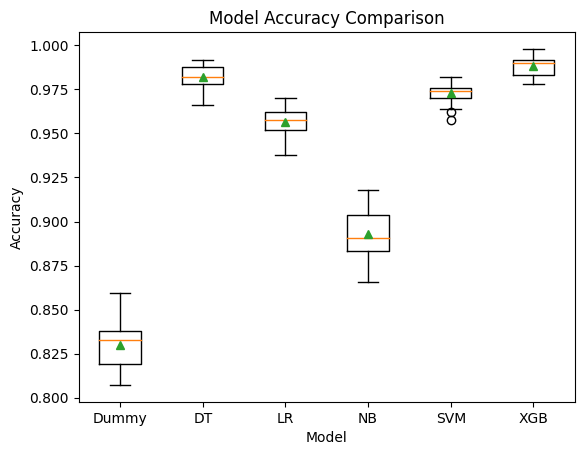

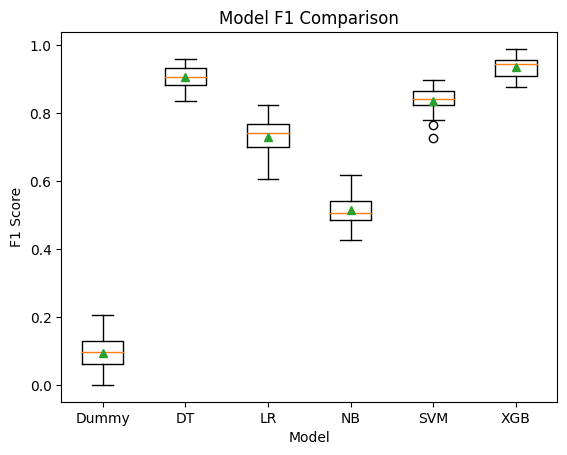

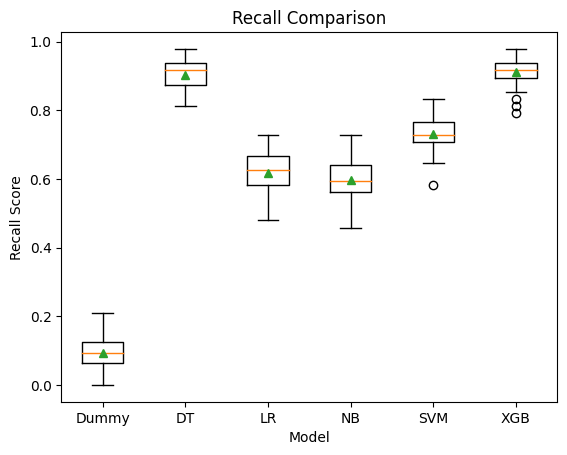

In [28]:
# define models
models, names = get_models()
accuracies = list()
f1_scores = list()
recalls = list()
# evaluate each model
for i in range(len(models)):

	numeric_transformer = Pipeline(
		steps=[("num_imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())]
		)
	categorical_transformer = Pipeline(
		steps=[("cat_imputer", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown="ignore"))]
	)

	ct = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_ix),
        ("cat", categorical_transformer, cat_ix),
    ]
)
	# wrap the model i a pipeline
	pipeline = Pipeline(steps=[('t',ct),('m',models[i])])
	# evaluate the model and store results
	scores = evaluate_model(X, y, pipeline)
	accuracies.append(scores['test_accuracy'])
	f1_scores.append(scores['test_f1'])
	recalls.append(scores['test_recall'])
	# summarize performance
	print(names[i])
	print(f"Average Accuracy: {np.round(np.mean(scores['test_accuracy']), 3)} ({np.round(np.std(scores['test_accuracy']), 3)})")
	print(f"Average F1: {np.round(np.mean(scores['test_f1']), 3)} ({np.round(np.std(scores['test_f1']), 3)})")
	print(f"Average Precision: {np.round(np.mean(scores['test_precision']), 3)} ({np.round(np.std(scores['test_precision']), 3)})")
	print(f"Average Recall: {np.round(np.mean(scores['test_recall']), 3)} ({np.round(np.std(scores['test_recall']), 3)})")
	print(f"Average ROC-AUC: {np.round(np.mean(scores['test_roc_auc']), 3)} ({np.round(np.std(scores['test_roc_auc']), 3)})")
	print()

# plot the results
plt.boxplot(accuracies, labels=names, showmeans=True)
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()

# plot the results
plt.boxplot(f1_scores, labels=names, showmeans=True)
plt.title("Model F1 Comparison")
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.show()

# plot the results
plt.boxplot(recalls, labels=names, showmeans=True)
plt.title("Recall Comparison")
plt.xlabel("Model")
plt.ylabel("Recall Score")
plt.show()

XGBoost appears to be strongest accross the board. However, the dataset is imbalanced. We can rebalance it using SMOTE...

## Rebalancing with SMOTE

In [29]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

Dummy
Average Accuracy: 0.504 (0.021)
Average F1: 0.167 (0.022)
Average Precision: 0.1 (0.013)
Average Recall: 0.519 (0.075)
Average ROC-AUC: 0.495 (0.035)

DT
Average Accuracy: 0.983 (0.006)
Average F1: 0.915 (0.027)
Average Precision: 0.895 (0.048)
Average Recall: 0.937 (0.027)
Average ROC-AUC: 0.962 (0.013)

LR
Average Accuracy: 0.907 (0.011)
Average F1: 0.646 (0.03)
Average Precision: 0.511 (0.034)
Average Recall: 0.882 (0.035)
Average ROC-AUC: 0.963 (0.011)

NB
Average Accuracy: 0.89 (0.012)
Average F1: 0.592 (0.038)
Average Precision: 0.463 (0.035)
Average Recall: 0.824 (0.061)
Average ROC-AUC: 0.939 (0.013)

SVM
Average Accuracy: 0.97 (0.007)
Average F1: 0.859 (0.028)
Average Precision: 0.795 (0.044)
Average Recall: 0.937 (0.029)
Average ROC-AUC: 0.985 (0.01)

XGB
Average Accuracy: 0.988 (0.006)
Average F1: 0.939 (0.03)
Average Precision: 0.95 (0.038)
Average Recall: 0.93 (0.041)
Average ROC-AUC: 0.998 (0.002)



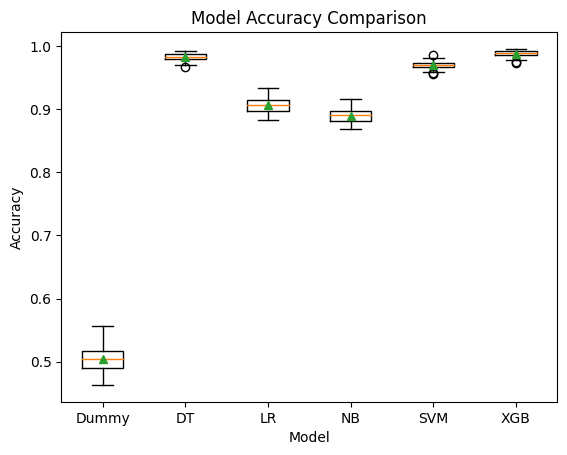

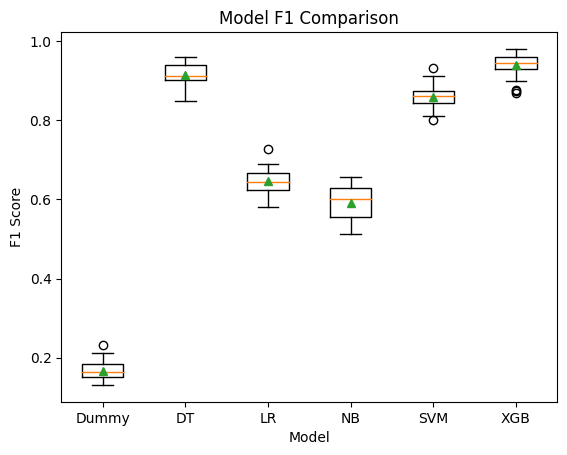

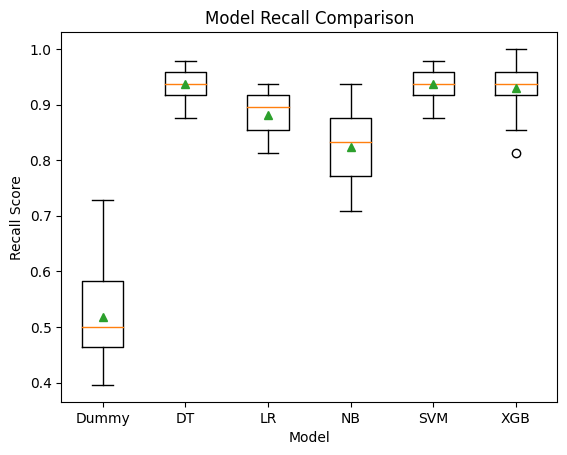

In [30]:
# define models
models, names = get_models()
accuracies = list()
f1_scores = list()
recalls = list()
# evaluate each model
for i in range(len(models)):

	numeric_transformer = Pipeline(
		steps=[("num_imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())]
		)
	categorical_transformer = Pipeline(
		steps=[("cat_imputer", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown="ignore"))]
	)

	ct = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_ix),
        ("cat", categorical_transformer, cat_ix),
    ]
)
	# wrap the model i a pipeline
	pipeline = Pipeline(steps=[('t',ct), ('over', SMOTE()), ('m',models[i])])
	# evaluate the model and store results
	scores = evaluate_model(X, y, pipeline)
	accuracies.append(scores['test_accuracy'])
	f1_scores.append(scores['test_f1'])
	recalls.append(scores['test_recall'])
	# summarize performance
	print(names[i])
	print(f"Average Accuracy: {np.round(np.mean(scores['test_accuracy']), 3)} ({np.round(np.std(scores['test_accuracy']), 3)})")
	print(f"Average F1: {np.round(np.mean(scores['test_f1']), 3)} ({np.round(np.std(scores['test_f1']), 3)})")
	print(f"Average Precision: {np.round(np.mean(scores['test_precision']), 3)} ({np.round(np.std(scores['test_precision']), 3)})")
	print(f"Average Recall: {np.round(np.mean(scores['test_recall']), 3)} ({np.round(np.std(scores['test_recall']), 3)})")
	print(f"Average ROC-AUC: {np.round(np.mean(scores['test_roc_auc']), 3)} ({np.round(np.std(scores['test_roc_auc']), 3)})")
	print()

# plot the results
plt.boxplot(accuracies, labels=names, showmeans=True)
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()

# plot the results
plt.boxplot(f1_scores, labels=names, showmeans=True)
plt.title("Model F1 Comparison")
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.show()

# plot the results
plt.boxplot(recalls, labels=names, showmeans=True)
plt.title("Model Recall Comparison")
plt.xlabel("Model")
plt.ylabel("Recall Score")
plt.show()

Oversampling the minority class using smote improved 'Recall' scores for every classifier. This is good for an imbalanced dataset, where we are trying to predict a minority class correctly.

Let's take the XGBoost Model, with SMOTE, and apply some hyperparameter tuning.